In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# IMAGE DATA HANDLING

In [2]:
training_path = r"C:\Users\Rahul\OneDrive\Desktop\projects\datasets\sartajbhuvaji\brain-tumor-classification-mri\versions\2\Training"
testing_path = r"C:\Users\Rahul\OneDrive\Desktop\projects\datasets\sartajbhuvaji\brain-tumor-classification-mri\versions\2\Testing"

In [3]:
#FUNCTION TO EXTRACT DATA

def path_to_df(dir_path):
    data = pd.DataFrame(columns=["label","image_array"])
    list_training_data = os.listdir(dir_path)
    target_size = (128,128)
    for i in list_training_data:
        path_i = os.path.join(dir_path,i)
        for j in os.listdir(path_i):
            full_path = os.path.join(path_i,j)
            image = Image.open(full_path).convert('L') #converting image to greyscale
            image = image.resize(target_size)          #changing image size
            image_array = np.array(image)              #converting to numpy array
            new_row = pd.DataFrame({"label":i,"image_array":[image_array]})
            data = pd.concat([data,new_row],ignore_index = True)
    return data

In [4]:
training_data = path_to_df(training_path)

In [5]:
testing_data = path_to_df(testing_path)

In [6]:
l = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
training_data_new = training_data.copy(deep=True)
testing_data_new = testing_data.copy(deep=True)

In [7]:
training_data_new['label'].replace(l,'tumor',inplace=True)
testing_data_new['label'].replace(l,'tumor',inplace=True)

C:\Users\Rahul\AppData\Local\Temp\ipykernel_14208\2596728997.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_data_new['label'].replace(l,'tumor',inplace=True)
C:\Users\Rahul\AppData\Local\Temp\ipykernel_14208\2596728997.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [8]:
#shuffling data
training_data_new = training_data_new.sample(len(training_data),ignore_index=True)
testing_data_new = testing_data_new.sample(len(testing_data),ignore_index=True)

In [9]:
#normalising data
training_data_new["image_array"] = training_data_new["image_array"]/255
testing_data_new['image_array'] = testing_data_new['image_array']/255


In [10]:
training_data_new.shape

(2870, 2)

In [11]:
testing_data_new.shape

(394, 2)

tumor


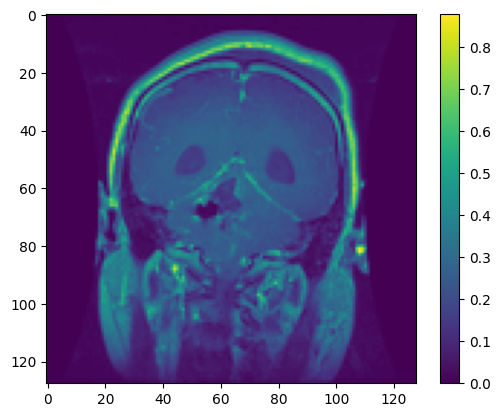

In [12]:
print(training_data_new['label'][49])
plt.imshow(training_data_new['image_array'][49])
plt.colorbar()

tumor


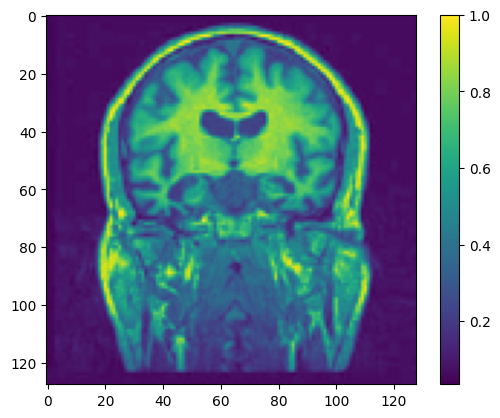

In [13]:
print(testing_data_new['label'][3])
plt.imshow(training_data_new['image_array'][3])
plt.colorbar()

# DEFINING MODELS

In [14]:
#CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_cnn_model_1(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_cnn_model_2(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### CROSS VALIDATION ON TRAINING SET

In [15]:
from sklearn.model_selection import StratifiedKFold

X = np.stack(training_data_new['image_array'].values)
X = X[..., np.newaxis]
y = training_data_new['label'].values

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)
print(dict(enumerate(le.classes_)))

{0: 'no_tumor', 1: 'tumor'}


In [17]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

acc_list = []
def validate_and_record(model_input,acc_list : list):
    for train_index, val_index in skf.split(X, y_encoded):
        
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y_categorical[train_index], y_categorical[val_index]
    
        # Build CNN model
        model = model_input(input_shape=X[0].shape, num_classes=2)  # Define this function
        
        # Train model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
        
        # Evaluate or store results
        val_loss, val_acc = model.evaluate(X_val, y_val)
        print(f"Validation accuracy: {val_acc:.4f}")
    val_acc = f"{val_acc:.4f}"
    acc_list.append(val_acc)
    return model , acc_list

In [18]:
model_1 ,acc_list = validate_and_record(build_cnn_model_1,acc_list)
print("\n\n\n\n\n\n")
model_2 ,acc_list = validate_and_record(build_cnn_model_2,acc_list)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - accuracy: 0.8426 - loss: 0.5105 - val_accuracy: 0.8624 - val_loss: 0.2674
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 235ms/step - accuracy: 0.8616 - loss: 0.2415 - val_accuracy: 0.8624 - val_loss: 0.1846
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 234ms/step - accuracy: 0.8841 - loss: 0.1898 - val_accuracy: 0.9286 - val_loss: 0.1647
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 243ms/step - accuracy: 0.9441 - loss: 0.1545 - val_accuracy: 0.9443 - val_loss: 0.1342
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 236ms/step - accuracy: 0.9276 - loss: 0.1564 - val_accuracy: 0.9564 - val_loss: 0.1190
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 235ms/step - accuracy: 0.9541 - loss: 0.1173 - val_accuracy: 0.9477 - val_loss: 0.1368
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 236ms/step - accuracy: 0.9500 - loss: 0.1107 - val_accuracy: 0.9355 - val_loss: 0.1413
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 238ms/step - accuracy: 0.9634 - loss: 0.0891 - val_accu

In [19]:
acc_list

['0.9460', '0.9477']

In [20]:
X_test_new = np.stack(testing_data_new['image_array'].values)
X_test_new = X_test_new[..., np.newaxis]

y_test_new = testing_data_new['label'].values
y_test_new = np.array(y_test_new)
y_test_encoded = le.fit_transform(y_test_new)
y_test_categorical = to_categorical(y_test_encoded)

In [21]:
y_pred1 = model_1.predict(X_test_new)
test_loss, test_acc = model_1.evaluate(X_test_new,y_test_categorical, verbose=2)
print(f"test_loss : {test_loss} \n test_acc : {test_acc}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step 
13/13 - 1s - 57ms/step - accuracy: 0.8350 - loss: 0.5217
test_loss : 0.5216702818870544 
 test_acc : 0.8350253701210022


In [22]:
y_pred2 = model_2.predict(X_test_new)
test_loss, test_acc = model_2.evaluate(X_test_new,y_test_categorical)
print(f"test_loss : {test_loss} \n test_acc : {test_acc}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8107 - loss: 0.5376
test_loss : 0.5232433676719666 
 test_acc : 0.8045685291290283


In [23]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred1_labels = np.argmax(y_pred1, axis=1)
y_test_labels = np.argmax(y_test_categorical, axis=1)
print(classification_report(y_test_labels, y_pred1_labels))
print(confusion_matrix(y_test_labels, y_pred1_labels))

              precision    recall  f1-score   support

           0       0.63      0.90      0.75       105
           1       0.96      0.81      0.88       289

    accuracy                           0.84       394
   macro avg       0.80      0.86      0.81       394
weighted avg       0.87      0.84      0.84       394

[[ 95  10]
 [ 55 234]]


In [24]:
print(dict(enumerate(le.classes_)))


{0: 'no_tumor', 1: 'tumor'}


In [25]:
from sklearn.metrics import auc,roc_curve,RocCurveDisplay,roc_auc_score

In [31]:
from sklearn.metrics import roc_curve

# Convert one-hot to class labels
y_true = y_test_categorical.argmax(axis=1)

# Use predicted probabilities for the positive class (class 1)
y_score1 = y_pred1[:, 1]
y_score2 = y_pred2[:, 1]

fpr1, tpr1, thresholds1 = roc_curve(y_true, y_score1)
fpr2, tpr2, thresholds2 = roc_curve(y_true, y_score2)
auc1=auc(fpr1,tpr1)
auc2=auc(fpr2,tpr2)


a = RocCurveDisplay(fpr=fpr1,tpr=tpr1,roc_auc=auc1,estimator_name='model_1')
b= RocCurveDisplay(fpr=fpr2,tpr=tpr2,roc_auc=auc2,estimator_name='model_2')

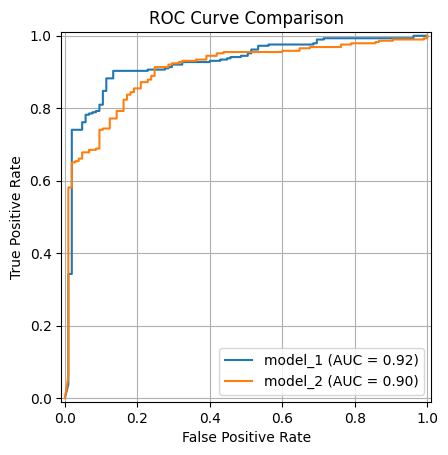

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the first ROC curve on the axes
a = RocCurveDisplay(fpr=fpr1, tpr=tpr1, roc_auc=auc1, estimator_name='model_1')
a.plot(ax=ax)

# Plot the second ROC curve on the same axes
b = RocCurveDisplay(fpr=fpr2, tpr=tpr2, roc_auc=auc2, estimator_name='model_2')
b.plot(ax=ax)

# Optional: customize the plot
plt.title("ROC Curve Comparison")
plt.grid(True)
plt.show()
